In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import nilearn
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_modules, level_dictionary, level_from_tree
from tree_features import T_from_level, adj_matrices_from_level, brain_maps_network_measure, threshold_based_similarity_external, density_threshold
from tree_features import tree_dictionary, get_module_vol, cross_modularity, add_gamma_to_lvl_dict, threshold_based_similarity, modularity, network_from_level
from tree_features import measure_betweenness, measure_strength, measure_clustering_coef, measure_pathlength, get_atlas_rois_from_mask
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
import networkx as nx

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/antoniojm/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [6]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/schaefer"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))

In [7]:
fcm, scm = connectome_average(fc_group, sc_group)
print(fcm.shape)
print(scm.shape)

(1000, 1000)
(1000, 1000)


In [182]:
density = np.where(scm.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm.flatten()))
fcm_thr = density_threshold(fcm, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
zero_rows_fc

array([289, 290, 293, 830])

In [183]:
#remove the element zero_rows from fcm and scm
fcm_thr_nonzero = np.delete(fcm_thr, zero_rows_fc, axis=0)
fcm_thr_nonzero = np.delete(fcm_thr_nonzero, zero_rows_fc, axis=1)
scm_nonzero = np.delete(scm, zero_rows_fc, axis=0)
scm_nonzero = np.delete(scm_nonzero, zero_rows_fc, axis=1)
fcm_bin = np.where(fcm_thr_nonzero > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 
print(fcm_bin.shape)
print(scm_bin.shape)

(996, 996)
(996, 996)


Text(0.5, 1.0, 'Structural connectivity matrix')

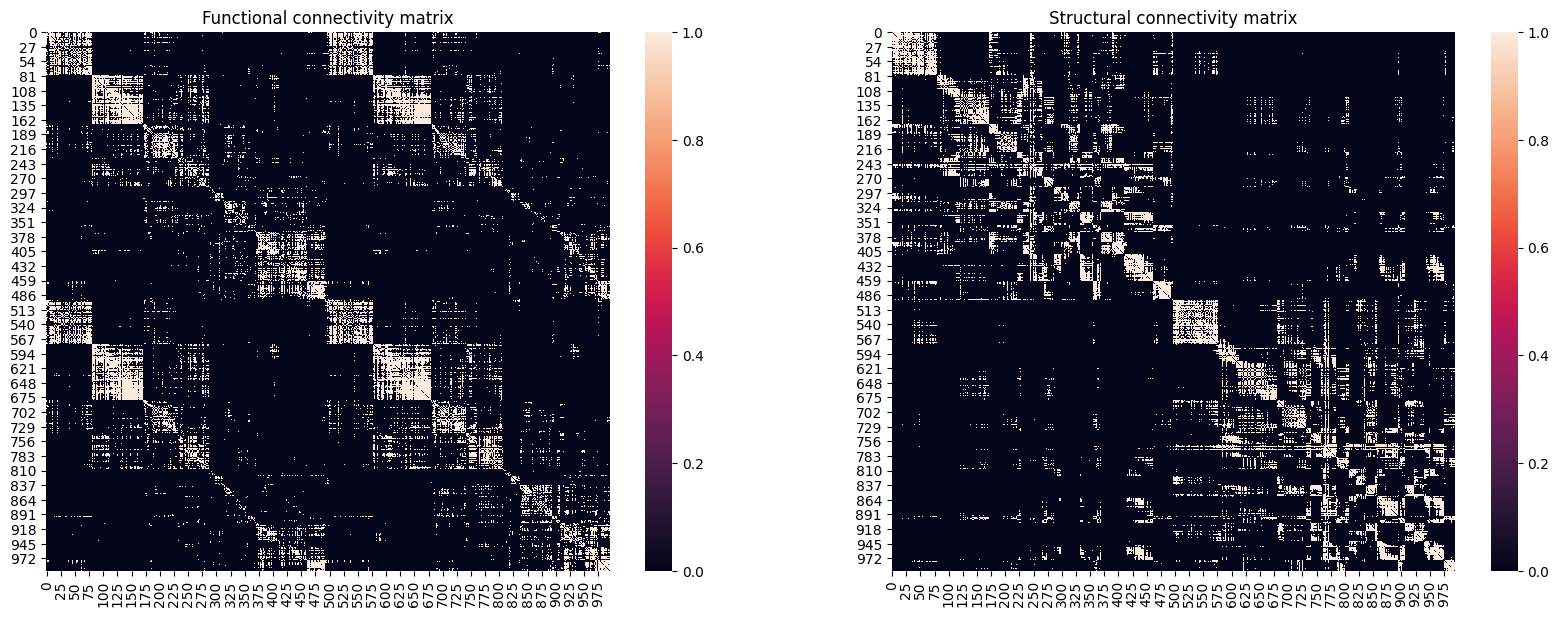

In [184]:
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_bin, ax=ax[0])
ax[0].set_title("Functional connectivity matrix")
sns.heatmap(scm_bin, ax=ax[1])
ax[1].set_title("Structural connectivity matrix")

In [185]:
def module_segregation(matrix, rois):
    m = sum(matrix.flatten())
    mc = matrix[rois][:, rois]
    return sum(mc.flatten()) / m

def module_integration(matrix, rois):
    m = sum(matrix.flatten())
    ext_rois = np.setdiff1d(np.array([i for i in range(len(matrix))]), rois)
    mc = matrix[rois][:, rois]
    ec = matrix[rois][:,ext_rois]
    ec_m = sum(ec.flatten()) / m
    term = np.power((2*sum(mc.flatten()) + sum(ec.flatten())) / (2*m), 2)
    return ec_m, term

def module_similarity(a,b,rois):
    module_a = a[rois][:, rois]
    module_b = b[rois][:, rois]
    sim = (2*np.multiply(module_a, module_b).sum() 
               / (module_a.sum() + module_b.sum()))
    return sim

def get_esp_params(matrix, rois):
    m = sum(matrix.flatten())
    ext_rois = np.setdiff1d(np.array([i for i in range(len(matrix))]), rois)
    mc = matrix[rois][:, rois]
    ec = matrix[rois][:,ext_rois]
    a = sum(mc.flatten())/m + (sum(ec.flatten())/m)/2
    b = np.sqrt(sum(mc.flatten())/m)
    return a,b

In [186]:
roi_labels = pd.read_csv(os.path.join(project_path, "labels_desc.csv"))
roi_labels = roi_labels.drop(zero_rows_fc)
roi_labels = roi_labels.reset_index(drop=True)
roi_labels["ROI Label"] = roi_labels.index + 1


Pattern:  Vis
Number of ROIs:  162
Pattern:  SomMot
Number of ROIs:  194
Pattern:  DorsAttn
Number of ROIs:  122
Pattern:  SalVentAttn
Number of ROIs:  121
Pattern:  Limbic
Number of ROIs:  56
Pattern:  Cont
Number of ROIs:  129
Pattern:  Default
Number of ROIs:  212


Text(0.5, 1.0, 'Crossmodularity per RSN')

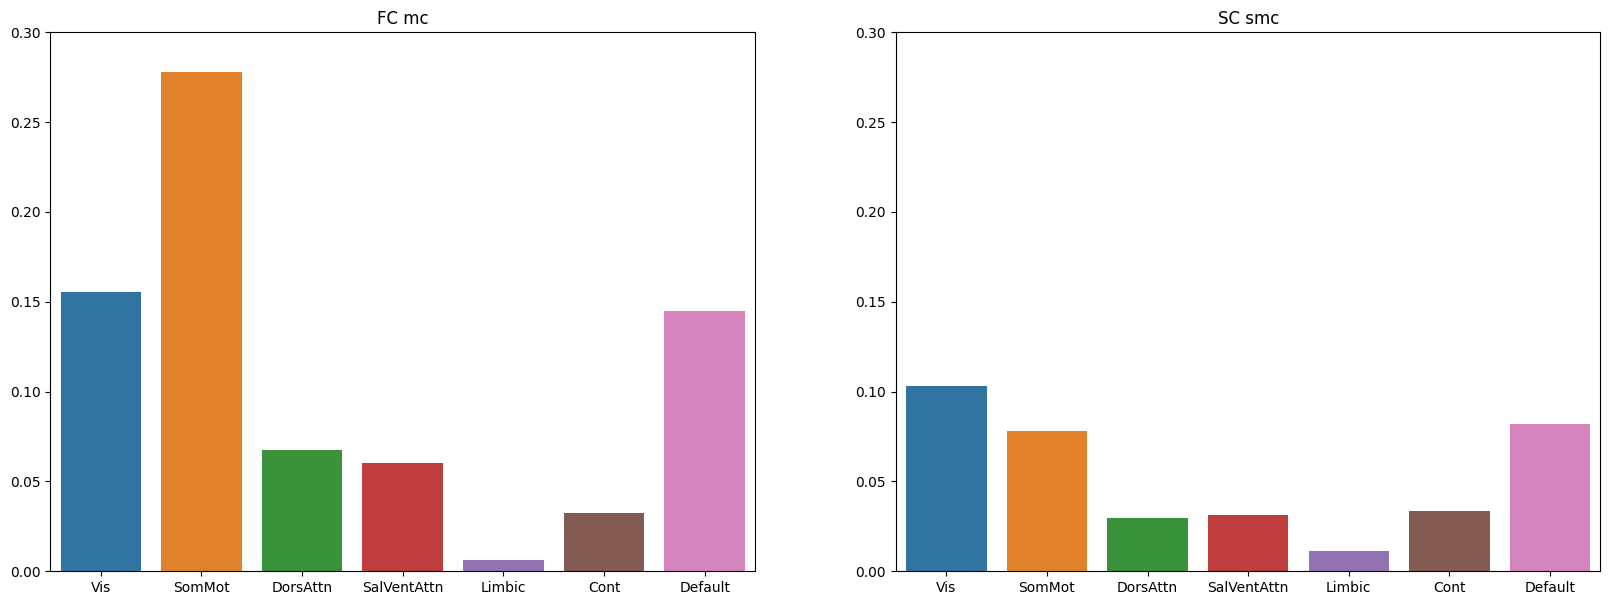

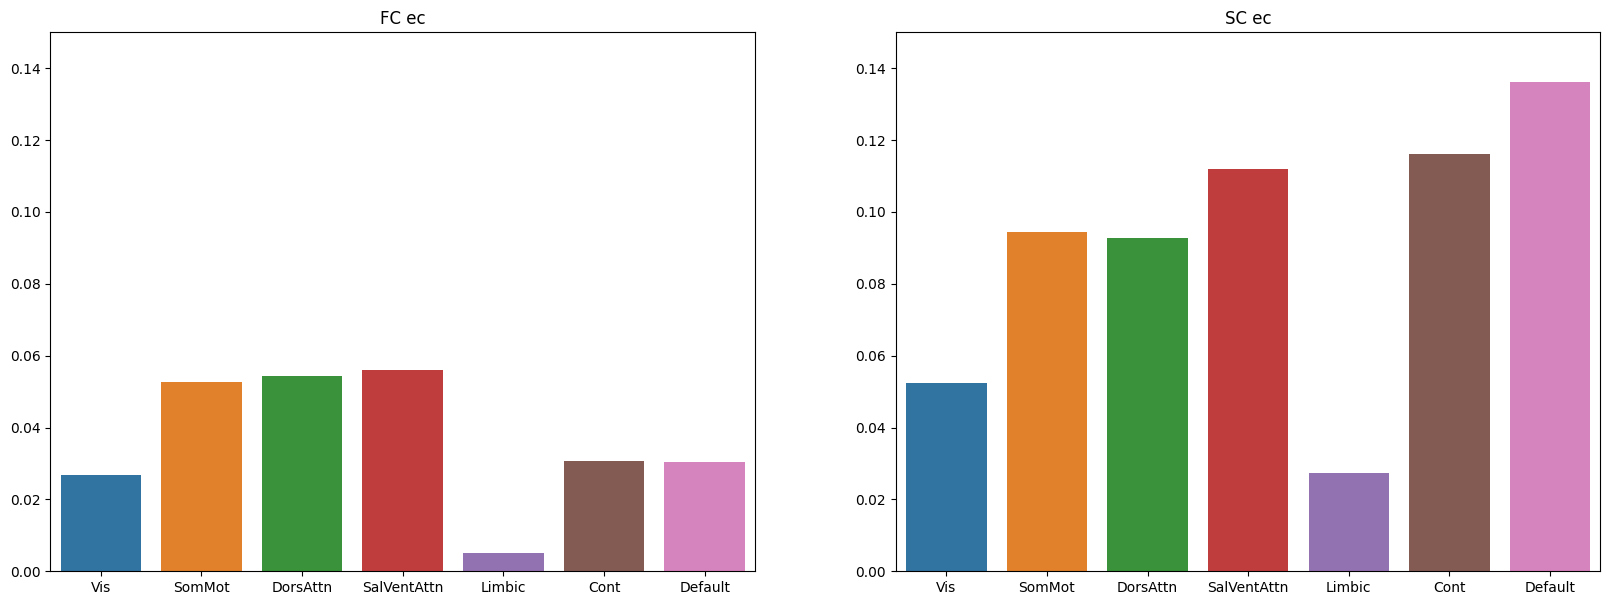

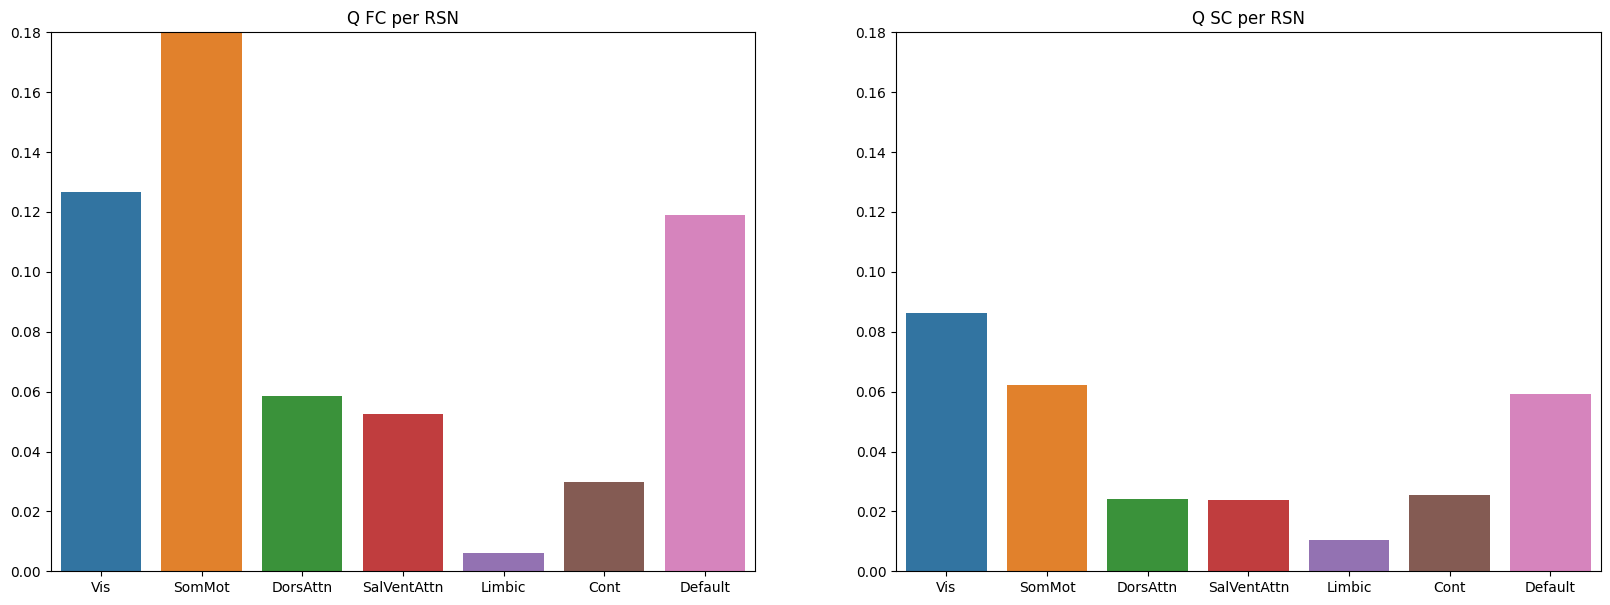

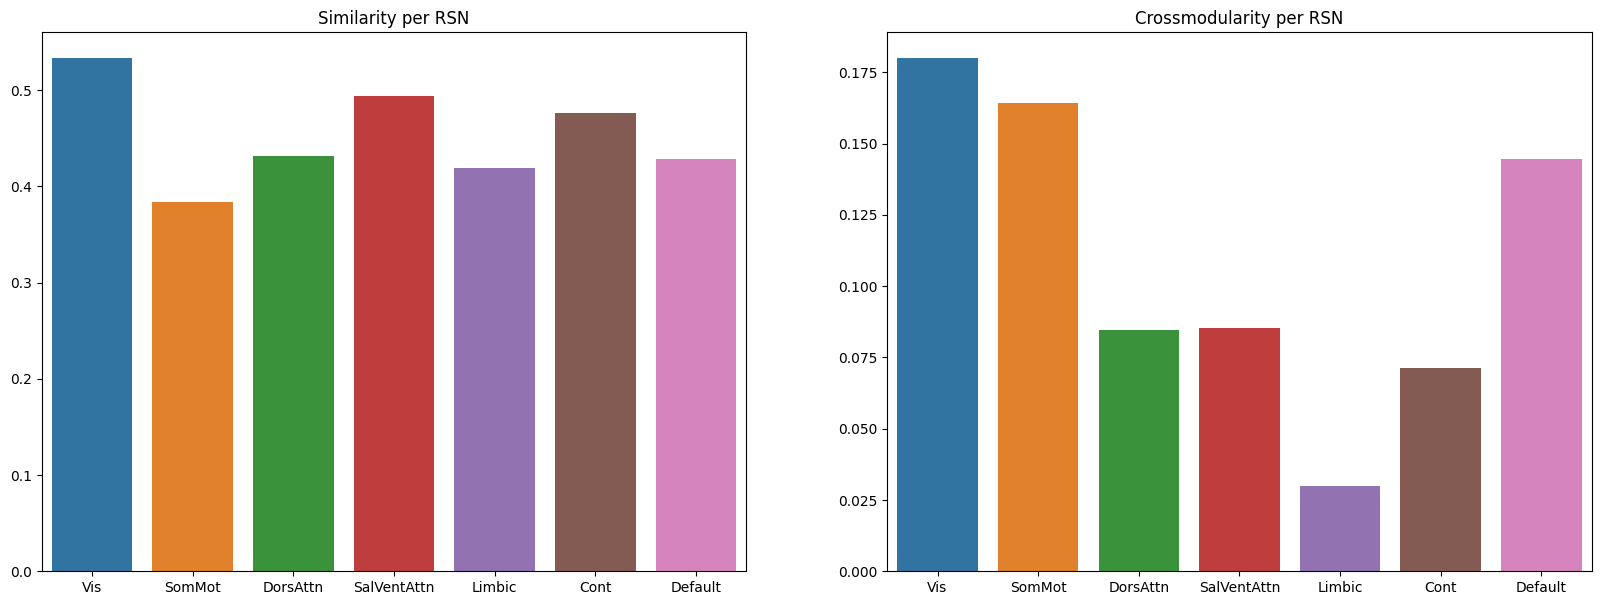

In [187]:

label_patterns = ["Vis", "SomMot", "DorsAttn", "SalVentAttn", "Limbic", "Cont", "Default"]

segregations_fc = []
integrations_fc = []
q_fc = []
segregations_sc = []
integrations_sc = []
q_sc = []
sim = []
cmod = []

for idx, pattern in enumerate(label_patterns):
    rois = roi_labels[roi_labels["ROI Name"].str.contains(pattern)]["ROI Label"].values - 1
    print("Pattern: ", pattern)
    print("Number of ROIs: ", len(rois))
    segregations_fc.append(module_segregation(fcm_bin, rois))
    e_fc, term_fc = module_integration(fcm_bin, rois)
    integrations_fc.append(e_fc)
    q_fc.append(segregations_fc[idx]-term_fc)
    segregations_sc.append(module_segregation(scm_bin, rois))
    e_sc, term_sc = module_integration(scm_bin, rois)
    integrations_sc.append(e_sc)
    q_sc.append(segregations_sc[idx]-term_sc)
    sim.append(module_similarity(fcm_bin, scm_bin, rois))
    cmod.append(pow((sim[idx] * q_fc[idx] * q_sc[idx]), (1 / 3)))

#plot segregations_fc with discrete values in seaborn
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(x=label_patterns, y=segregations_fc, ax=ax[0])
ax[0].set_title("FC mc")
ax[0].set_ylim(0, 0.3)
sns.barplot(x=label_patterns, y=segregations_sc, ax=ax[1])
ax[1].set_title("SC smc")
ax[1].set_ylim(0, 0.3)

#plot integrations_fc with discrete values in seaborn
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(x=label_patterns, y=integrations_fc, ax=ax[0])
ax[0].set_title("FC ec")
ax[0].set_ylim(0, 0.15)
sns.barplot(x=label_patterns, y=integrations_sc, ax=ax[1])
ax[1].set_title("SC ec")
ax[1].set_ylim(0, 0.15)

#plot q_fc with discrete values in seaborn
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(x=label_patterns, y=q_fc, ax=ax[0])
ax[0].set_title("Q FC per RSN")
ax[0].set_ylim(0, 0.18)
sns.barplot(x=label_patterns, y=q_sc, ax=ax[1])
ax[1].set_title("Q SC per RSN")
ax[1].set_ylim(0, 0.18)

#plot q_fc with discrete values in seaborn
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.barplot(x=label_patterns, y=sim, ax=ax[0])
ax[0].set_title("Similarity per RSN")
sns.barplot(x=label_patterns, y=cmod, ax=ax[1])
ax[1].set_title("Crossmodularity per RSN")


In [188]:
q_fc_total = sum(q_fc)
q_sc_total = sum(q_sc)

print(q_fc_total)
print(q_sc_total)

0.578260363924354
0.2916191482986459


In [156]:
T = np.zeros(len(roi_labels), dtype=int)

for idx, pattern in enumerate(label_patterns):
    rois = roi_labels[roi_labels["ROI Name"].str.contains(pattern)]["ROI Label"].values - 1
    T[rois] = idx+1

q_fc_old = modularity(fcm_bin, T)
q_sc_old = modularity(scm_bin, T)

print(q_fc_old)
print(q_sc_old)

0.5383726198791178
0.20802534709747025


In [159]:
for idx, pattern in enumerate(label_patterns):
    rois = roi_labels[roi_labels["ROI Name"].str.contains(pattern)]["ROI Label"].values - 1
    a_fc,b_fc = get_esp_params(fcm_bin, rois)
    print("FC-> {} has term1 = {:.2f} and term2 = {:.2f}".format(pattern, a_fc, b_fc))
    if a_fc>b_fc:
        print("FC-> {} is spontaneous".format(pattern))
    
    a_sc,b_sc = get_esp_params(scm_bin, rois)
    if a_sc>b_sc:
        print("SC-> {} is spontaneous".format(pattern))
    print("SC-> {} has term1 = {:.2f} and term2 = {:.2f}".format(pattern, a_sc, b_sc))

FC-> Vis has term1 = 0.17 and term2 = 0.39
SC-> Vis has term1 = 0.13 and term2 = 0.32
FC-> SomMot has term1 = 0.30 and term2 = 0.53
SC-> SomMot has term1 = 0.13 and term2 = 0.28
FC-> DorsAttn has term1 = 0.09 and term2 = 0.26
SC-> DorsAttn has term1 = 0.08 and term2 = 0.17
FC-> SalVentAttn has term1 = 0.09 and term2 = 0.25
SC-> SalVentAttn has term1 = 0.09 and term2 = 0.18
FC-> Limbic has term1 = 0.01 and term2 = 0.08
SC-> Limbic has term1 = 0.02 and term2 = 0.11
FC-> Cont has term1 = 0.05 and term2 = 0.18
SC-> Cont has term1 = 0.09 and term2 = 0.18
FC-> Default has term1 = 0.16 and term2 = 0.38
SC-> Default has term1 = 0.15 and term2 = 0.29
